Mục đích: nạp thư viện, đặt seed, cấu hình hiển thị

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

SEED = 42
np.random.seed(SEED)
sns.set(style="whitegrid", palette="muted")
pd.set_option("display.max_columns", None)

PROC_DIR = Path("../data/processed")
REPORT_DIR = Path("../report/figures")
REPORT_DIR.mkdir(parents=True, exist_ok=True)


Mục đích: đọc dữ liệu đã xử lý từ Note 01

In [2]:
X_train = pd.read_csv(PROC_DIR / "X_train.csv", index_col=0)
X_test  = pd.read_csv(PROC_DIR / "X_test.csv",  index_col=0)
y_train = pd.read_csv(PROC_DIR / "y_train.csv", index_col=0)["status"]
y_test  = pd.read_csv(PROC_DIR / "y_test.csv",  index_col=0)["status"]

# (tuỳ chọn) đọc tên cột sau OHE để map hệ số
featnames_path = PROC_DIR / "feature_names.txt"
feature_names = None
if featnames_path.exists():
    feature_names = [ln.strip() for ln in open(featnames_path, "r", encoding="utf-8").read().splitlines()]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((172, 21), (43, 21), (172,), (43,))

Mục đích: kiểm tra lại kích thước và tỉ lệ lớp

In [3]:
print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Class balance (train):")
print(y_train.value_counts(normalize=True).round(3))
print("Class balance (test):")
print(y_test.value_counts(normalize=True).round(3))
assert X_train.shape[1] == X_test.shape[1], "Số cột train/test không khớp!"


Train: (172, 21) | Test: (43, 21)
Class balance (train):
status
1    0.686
0    0.314
Name: proportion, dtype: float64
Class balance (test):
status
1    0.698
0    0.302
Name: proportion, dtype: float64


Mục đích: fit mô hình baseline; dùng class_weight='none' trước để làm mốc

In [ ]:
logreg = LogisticRegression(
    penalty="l2",
    solver="lbfgs",     # dữ liệu không quá nhỏ, lbfgs ổn định
    max_iter=1000,
    random_state=SEED
)
logreg.fit(X_train, y_train)

print("Đã fit Logistic Regression baseline.")


Đã fit Logistic Regression baseline.


Mục đích: lấy y_pred (ngưỡng 0.5) và y_score (proba lớp 1)

In [5]:
y_score = logreg.predict_proba(X_test)[:, 1]
y_pred = (y_score >= 0.5).astype(int)

pd.Series(y_pred).value_counts()


1    28
0    15
Name: count, dtype: int64

Mục đích: in accuracy, precision, recall, f1, ROC AUC, PR AUC

In [6]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_score)
prA  = average_precision_score(y_test, y_score)  # PR AUC

print(f"Accuracy : {acc: .3f}")
print(f"Precision: {prec: .3f}")
print(f"Recall   : {rec: .3f}")
print(f"F1-score : {f1: .3f}")
print(f"ROC AUC  : {roc: .3f}")
print(f"PR  AUC  : {prA: .3f}")


Accuracy :  0.860
Precision:  0.929
Recall   :  0.867
F1-score :  0.897
ROC AUC  :  0.938
PR  AUC  :  0.976


Mục đích: trực quan hoá dự đoán đúng/sai

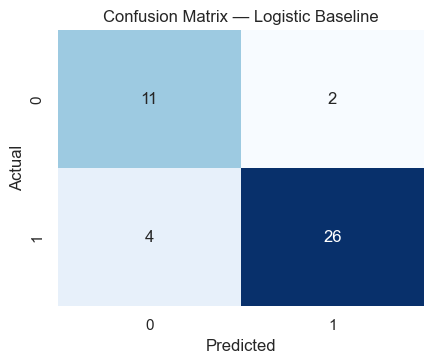

In [7]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.5,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Baseline")
plt.tight_layout()
plt.savefig(REPORT_DIR / "confusion_matrix.png", dpi=150)
plt.show()


Mục đích: trực quan năng lực phân biệt theo các ngưỡng khác nhau

<Figure size 480x380 with 0 Axes>

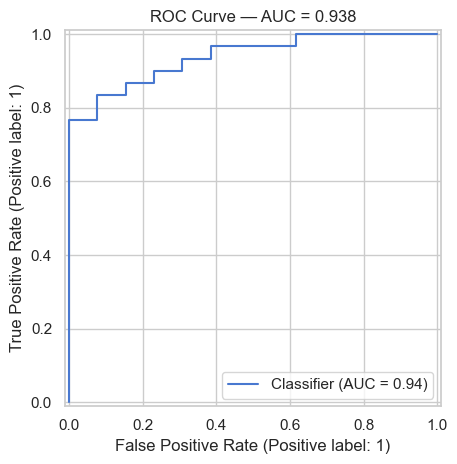

In [8]:
plt.figure(figsize=(4.8,3.8))
RocCurveDisplay.from_predictions(y_test, y_score)
plt.title(f"ROC Curve — AUC = {roc_auc_score(y_test, y_score):.3f}")
plt.tight_layout()
plt.savefig(REPORT_DIR / "roc_curve.png", dpi=150)
plt.show()


Mục đích: hữu ích khi dữ liệu mất cân bằng

<Figure size 480x380 with 0 Axes>

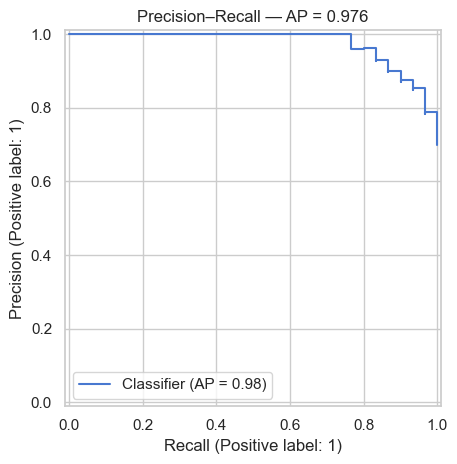

In [9]:
plt.figure(figsize=(4.8,3.8))
PrecisionRecallDisplay.from_predictions(y_test, y_score)
plt.title(f"Precision–Recall — AP = {average_precision_score(y_test, y_score):.3f}")
plt.tight_layout()
plt.savefig(REPORT_DIR / "pr_curve.png", dpi=150)
plt.show()


Mục đích: xem đặc trưng tác động mạnh nhất (tăng/giảm xác suất)

In [10]:
coef = logreg.coef_.ravel()
if feature_names is None or len(feature_names) != len(coef):
    feature_names = [f"f{i}" for i in range(len(coef))]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "odds_ratio": np.exp(coef)
}).sort_values("coef", ascending=False)

display(coef_df.head(15).style.format({"coef": "{:.3f}", "odds_ratio": "{:.3f}"}))
display(coef_df.tail(15).sort_values("coef").style.format({"coef": "{:.3f}", "odds_ratio": "{:.3f}"}))


,feature,coef,odds_ratio
16,ssc_p,1.853,6.379
18,degree_p,1.095,2.990
17,hsc_p,0.904,2.470
13,workex_Yes,0.847,2.332
9,degree_t_Comm&Mgmt,0.645,1.906
1,gender_M,0.501,1.650
3,ssc_b_Others,0.344,1.411
6,hsc_s_Arts,0.309,1.362
4,hsc_b_Central,0.129,1.138
14,specialisation_Mkt&Fin,0.057,1.059


,feature,coef,odds_ratio
20,mba_p,-0.961,0.382
12,workex_No,-0.846,0.429
11,degree_t_Sci&Tech,-0.556,0.574
0,gender_F,-0.501,0.606
2,ssc_b_Central,-0.344,0.709
7,hsc_s_Commerce,-0.163,0.850
8,hsc_s_Science,-0.146,0.864
5,hsc_b_Others,-0.129,0.879
10,degree_t_Others,-0.089,0.915
15,specialisation_Mkt&HR,-0.057,0.945


Mục đích: tìm ngưỡng tốt hơn 0.5 nếu cần cân bằng Precision–Recall

In [11]:
thresholds = np.linspace(0, 1, 201)
f1_scores, youdens = [], []

for t in thresholds:
    yp = (y_score >= t).astype(int)
    f1_scores.append(f1_score(y_test, yp, zero_division=0))
    # Youden's J = TPR - FPR
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    # (để nhanh có thể ước lượng J tại t, nhưng chuẩn nhất là lấy max(tpr-fpr) từ đường ROC)
    break

# Cách nhanh: lấy ngưỡng tối đa F1
best_t = thresholds[np.argmax(f1_scores)]
print(f"Ngưỡng tối ưu theo F1 ~ {best_t:.2f}, F1_max = {np.max(f1_scores):.3f}")


Ngưỡng tối ưu theo F1 ~ 0.00, F1_max = 0.822


Mục đích: thử đối phó mất cân bằng lớp; không ghi đè mô hình baseline

In [12]:
logreg_bal = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced",
    max_iter=1000,
    random_state=SEED
)
logreg_bal.fit(X_train, y_train)
y_score_bal = logreg_bal.predict_proba(X_test)[:, 1]
y_pred_bal = (y_score_bal >= 0.5).astype(int)

print("Balanced —",
      "ACC:", f"{accuracy_score(y_test, y_pred_bal):.3f}",
      "| F1:", f"{f1_score(y_test, y_pred_bal, zero_division=0):.3f}",
      "| ROC AUC:", f"{roc_auc_score(y_test, y_score_bal):.3f}",
      "| PR AUC:", f"{average_precision_score(y_test, y_score_bal):.3f}")


Balanced — ACC: 0.860 | F1: 0.893 | ROC AUC: 0.938 | PR AUC: 0.975
